# Buffer Stock Model

# Setup

In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import numba as nb
import matplotlib.pyplot as plt


# load the BufferStockModel module
from BufferStockModel import BufferStockModelClass

# for timing
from consav.misc import elapsed

nb.set_num_threads(1) # use a single thread for clarity

# Solve with EGM

Load Buffer Stock Model to be solved with NEGM:

In [2]:
model_egm = BufferStockModelClass(name='baseline',par={'solmethod':'egm'})

Solve the model with EGM:

In [3]:
model_egm.solve()

 t = 59 solved in 1.0 secs
 t = 59 solved in 0.0 secs
 t = 59 solved in 0.0 secs
 t = 58 solved in 5.0 secs (w: 3.3 secs)
 t = 58 solved in 0.5 secs (w: 0.5 secs)
 t = 58 solved in 0.5 secs (w: 0.5 secs)
 t = 57 solved in 0.5 secs (w: 0.5 secs)
 t = 57 solved in 0.5 secs (w: 0.5 secs)
 t = 57 solved in 0.5 secs (w: 0.5 secs)
 t = 56 solved in 0.5 secs (w: 0.5 secs)
 t = 56 solved in 0.5 secs (w: 0.5 secs)
 t = 56 solved in 0.5 secs (w: 0.5 secs)
 t = 55 solved in 0.5 secs (w: 0.5 secs)
 t = 55 solved in 0.5 secs (w: 0.5 secs)
 t = 55 solved in 0.5 secs (w: 0.5 secs)
 t = 54 solved in 0.5 secs (w: 0.5 secs)
 t = 54 solved in 0.5 secs (w: 0.5 secs)
 t = 54 solved in 0.5 secs (w: 0.5 secs)
 t = 53 solved in 0.5 secs (w: 0.5 secs)
 t = 53 solved in 0.5 secs (w: 0.5 secs)
 t = 53 solved in 0.5 secs (w: 0.5 secs)
 t = 52 solved in 0.6 secs (w: 0.6 secs)
 t = 52 solved in 0.5 secs (w: 0.5 secs)
 t = 52 solved in 0.5 secs (w: 0.5 secs)
 t = 51 solved in 0.5 secs (w: 0.5 secs)
 t = 51 solved in

Simulate EGM-solved model with updated simulate function `simulate_rand`, that randomly assigns different beta values to households:

In [4]:
model_egm.simulate()

model simulated in 2.7 secs


In [5]:
model_egm.simulate_rand()

model simulated in 2.3 secs


Plot lifecycles of model solved with EGM:

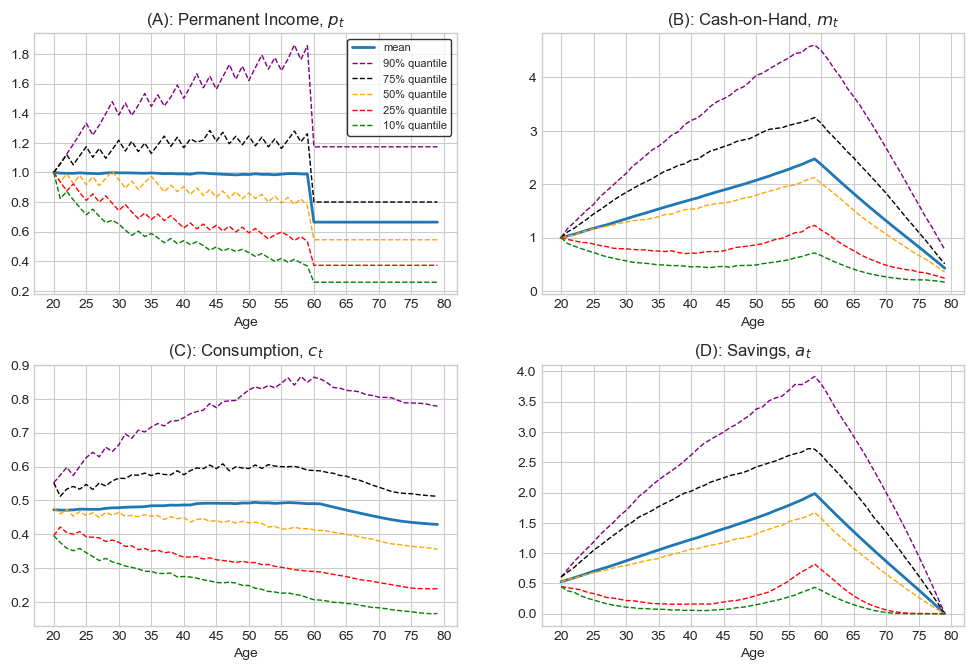

In [6]:
model_egm.lifecycle()

## Various checks

Below checks simulation values for different values of beta (households):

In [7]:
# This saves simualtes the model and put simulation results in model.sim
model_egm.simulate()

model simulated in 0.0 secs


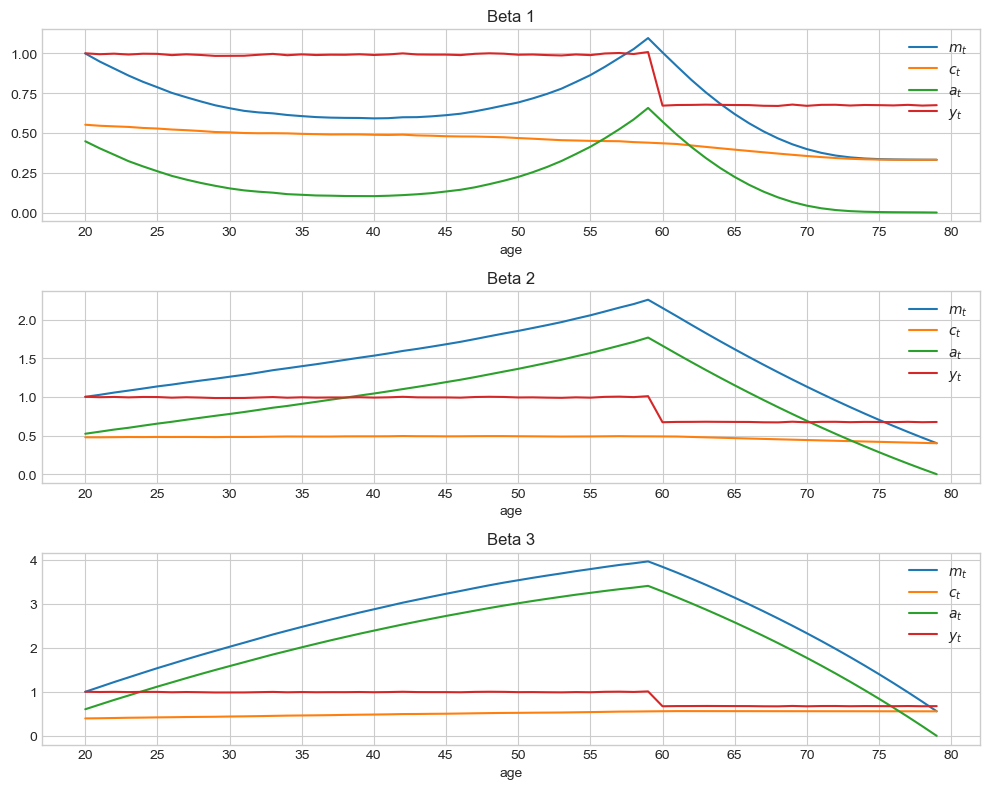

In [8]:
model_egm.beta_check()

In a single graph:

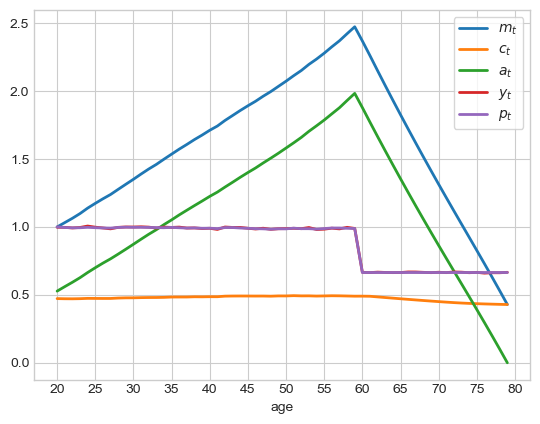

In [9]:
model_egm.beta_check_simple()

# Tax Shocks

## Transitory Anticipated Tax Increase

Create a copy of the original model solve with EGM and implement anticipated transitory tax increase in period 20 (i.e. 21):

In [10]:
model_egm_trans5pct = model_egm.copy()
model_egm_trans5pct.par.tax_rate_vec[20] = model_egm.par.tax_rate_vec[20]*1.05

Check tax array to see that a transitory shock has been implemented:

In [11]:
# ensuring tax has hikened
model_egm_trans5pct.par.tax_rate_vec

array([0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  , 0.5355, 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  ])

Solve and simulate new model with anticipated transitory shock (using `simulate_rand` that assigns different beta values to different households): 

In [12]:
model_egm_trans5pct.solve()
model_egm_trans5pct.simulate()
model_egm_trans5pct.simulate_rand()

 t = 59 solved in 0.0 secs
 t = 59 solved in 0.0 secs
 t = 59 solved in 0.0 secs
 t = 58 solved in 0.5 secs (w: 0.5 secs)
 t = 58 solved in 0.5 secs (w: 0.5 secs)
 t = 58 solved in 0.5 secs (w: 0.5 secs)
 t = 57 solved in 0.5 secs (w: 0.5 secs)
 t = 57 solved in 0.5 secs (w: 0.5 secs)
 t = 57 solved in 0.5 secs (w: 0.5 secs)
 t = 56 solved in 0.5 secs (w: 0.5 secs)
 t = 56 solved in 0.5 secs (w: 0.5 secs)
 t = 56 solved in 0.5 secs (w: 0.5 secs)
 t = 55 solved in 0.6 secs (w: 0.6 secs)
 t = 55 solved in 0.6 secs (w: 0.6 secs)
 t = 55 solved in 0.5 secs (w: 0.5 secs)
 t = 54 solved in 0.6 secs (w: 0.5 secs)
 t = 54 solved in 0.5 secs (w: 0.5 secs)
 t = 54 solved in 0.5 secs (w: 0.5 secs)
 t = 53 solved in 0.5 secs (w: 0.5 secs)
 t = 53 solved in 0.5 secs (w: 0.5 secs)
 t = 53 solved in 0.5 secs (w: 0.5 secs)
 t = 52 solved in 0.5 secs (w: 0.5 secs)
 t = 52 solved in 0.5 secs (w: 0.5 secs)
 t = 52 solved in 0.5 secs (w: 0.5 secs)
 t = 51 solved in 0.5 secs (w: 0.5 secs)
 t = 51 solved in

C:\Users\olive\AppData\Local\Temp\ipykernel_7840\97268309.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


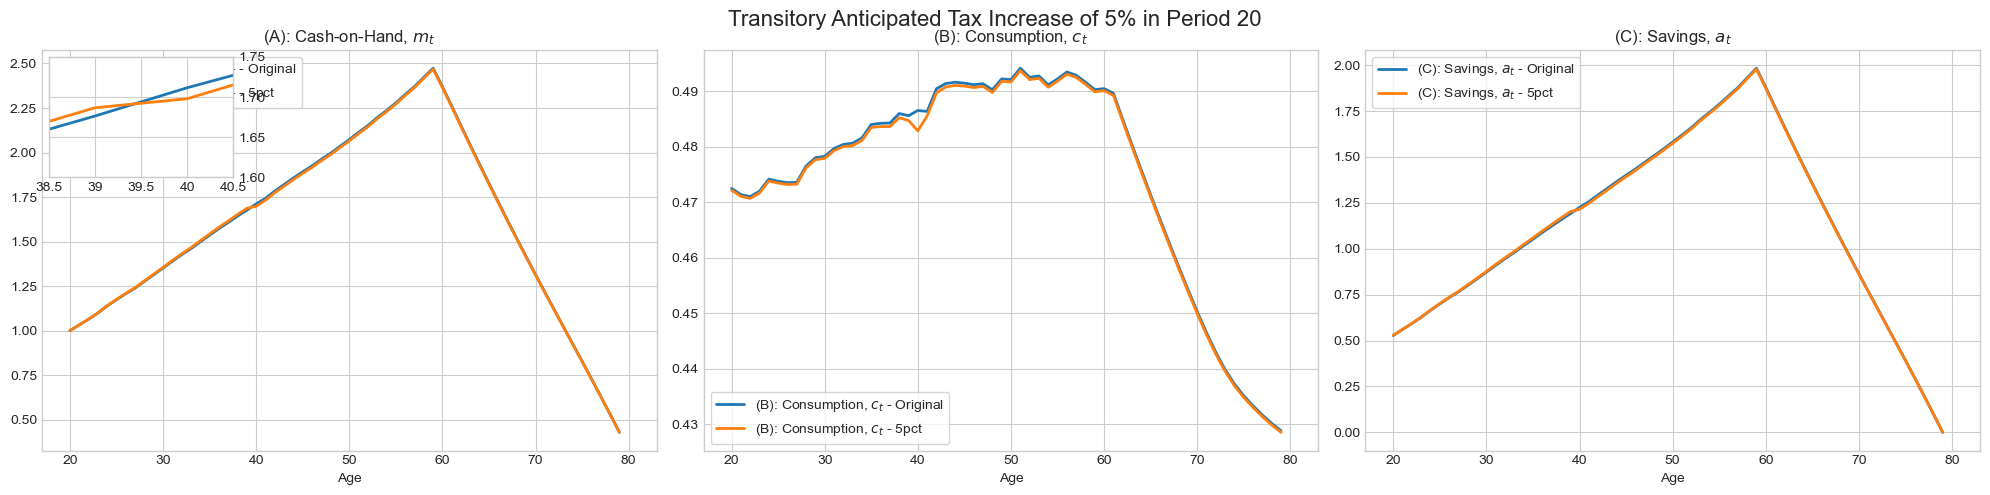

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# a. unpack
par = model_egm.par
sim = model_egm.sim
sim_trans5pct = model_egm_trans5pct.sim

simvarlist = [('m','(A): Cash-on-Hand, $m_t$'),
              ('c','(B): Consumption, $c_t$'),
              ('a','(C): Savings, $a_t$')]

# b. figure
fig, axs = plt.subplots(1, len(simvarlist), figsize=(20, 5))

# add a title over the entire figure
fig.suptitle("Transitory Anticipated Tax Increase of 5% in Period 20", fontsize=16)

age = np.arange(par.T)

for i, (simvar, simvarlatex) in enumerate(simvarlist):

    simdata = getattr(sim, simvar+'_rand')
    simdata_trans5pct = getattr(sim_trans5pct, simvar+'_rand')
    axs[i].plot(age, np.mean(simdata, axis=1), lw=2, label=f'{simvarlatex} - Original')
    axs[i].plot(age, np.mean(simdata_trans5pct, axis=1), lw=2, label=f'{simvarlatex} - 5pct')

    axs[i].legend(frameon=True)
    axs[i].grid(True)
    axs[i].set_xlabel('Age')
    axs[i].set_title(f'{simvarlatex}')

    # Change x-axis labels to show 20 years later
    xticks = axs[i].get_xticks()
    axs[i].set_xticks(xticks)  # Set tick positions, this line is actually redundant here because it's the same as before
    new_xticks = xticks + 20
    axs[i].set_xticklabels([int(val) if val.is_integer() else val for val in new_xticks])
    axs[i].set_xlim(-3, 63)

    # create zoom-in inset plot on the first graph
    if i == 0:
        axins = inset_axes(axs[i], width="30%", height="30%", loc='upper left')  # adjust size and position as needed
        axins.plot(age, np.mean(simdata, axis=1), lw=2)
        axins.plot(age, np.mean(simdata_trans5pct, axis=1), lw=2)

        # specify the limits for the zoomed-in plot
        axins.set_xlim(18.5, 20.5)
        axins.set_ylim(1.60,1.75)  # adjust as needed

        # Move labels to right
        axins.yaxis.tick_right()
        axins.yaxis.set_label_position("right")

        # Change x-axis labels for inset axes to show 20 years later
        xticks = axins.get_xticks()
        new_xticks = xticks + 20
        axins.set_xticks(xticks[::2])  # Keep every other tick
        axins.set_xticklabels([int(val) if val.is_integer() else val for val in new_xticks[::2]])  # Apply the same slicing to the labels

plt.tight_layout()
# Adjust the layout so that title does not overlap with the top plot
plt.subplots_adjust(top=0.9)
plt.show()

## Permanent Anticipated Tax Increase

Create a copy of the original model solve with EGM and anticipated permanent tax increase in period 21:

In [14]:
model_egm_5pct = model_egm.copy()
model_egm_5pct.par.tax_rate_vec[20:] = model_egm.par.tax_rate_vec[20:]*1.05

Check tax array to see that a permanent increase has been implemented:

In [15]:
model_egm_5pct.par.tax_rate_vec

array([0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  , 0.5355, 0.5355, 0.5355, 0.5355,
       0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355,
       0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355,
       0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355,
       0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355,
       0.5355, 0.5355, 0.5355, 0.5355])

Solve and simulate new model with permanent shock (using ´simulate_rand´ that assigns different beta values to different households): 

In [16]:
model_egm_5pct.solve()
model_egm_5pct.simulate()
model_egm_5pct.simulate_rand()

 t = 59 solved in 0.0 secs
 t = 59 solved in 0.0 secs
 t = 59 solved in 0.0 secs
 t = 58 solved in 0.6 secs (w: 0.6 secs)
 t = 58 solved in 0.5 secs (w: 0.5 secs)
 t = 58 solved in 0.6 secs (w: 0.6 secs)
 t = 57 solved in 0.7 secs (w: 0.7 secs)
 t = 57 solved in 0.6 secs (w: 0.6 secs)
 t = 57 solved in 0.7 secs (w: 0.7 secs)
 t = 56 solved in 0.6 secs (w: 0.6 secs)
 t = 56 solved in 0.6 secs (w: 0.5 secs)
 t = 56 solved in 0.6 secs (w: 0.6 secs)
 t = 55 solved in 0.7 secs (w: 0.7 secs)
 t = 55 solved in 0.7 secs (w: 0.6 secs)
 t = 55 solved in 0.7 secs (w: 0.7 secs)
 t = 54 solved in 0.6 secs (w: 0.6 secs)
 t = 54 solved in 0.7 secs (w: 0.7 secs)
 t = 54 solved in 0.7 secs (w: 0.7 secs)
 t = 53 solved in 0.8 secs (w: 0.8 secs)
 t = 53 solved in 0.7 secs (w: 0.6 secs)
 t = 53 solved in 0.6 secs (w: 0.6 secs)
 t = 52 solved in 0.7 secs (w: 0.7 secs)
 t = 52 solved in 0.8 secs (w: 0.8 secs)
 t = 52 solved in 1.1 secs (w: 1.1 secs)
 t = 51 solved in 0.9 secs (w: 0.9 secs)
 t = 51 solved in

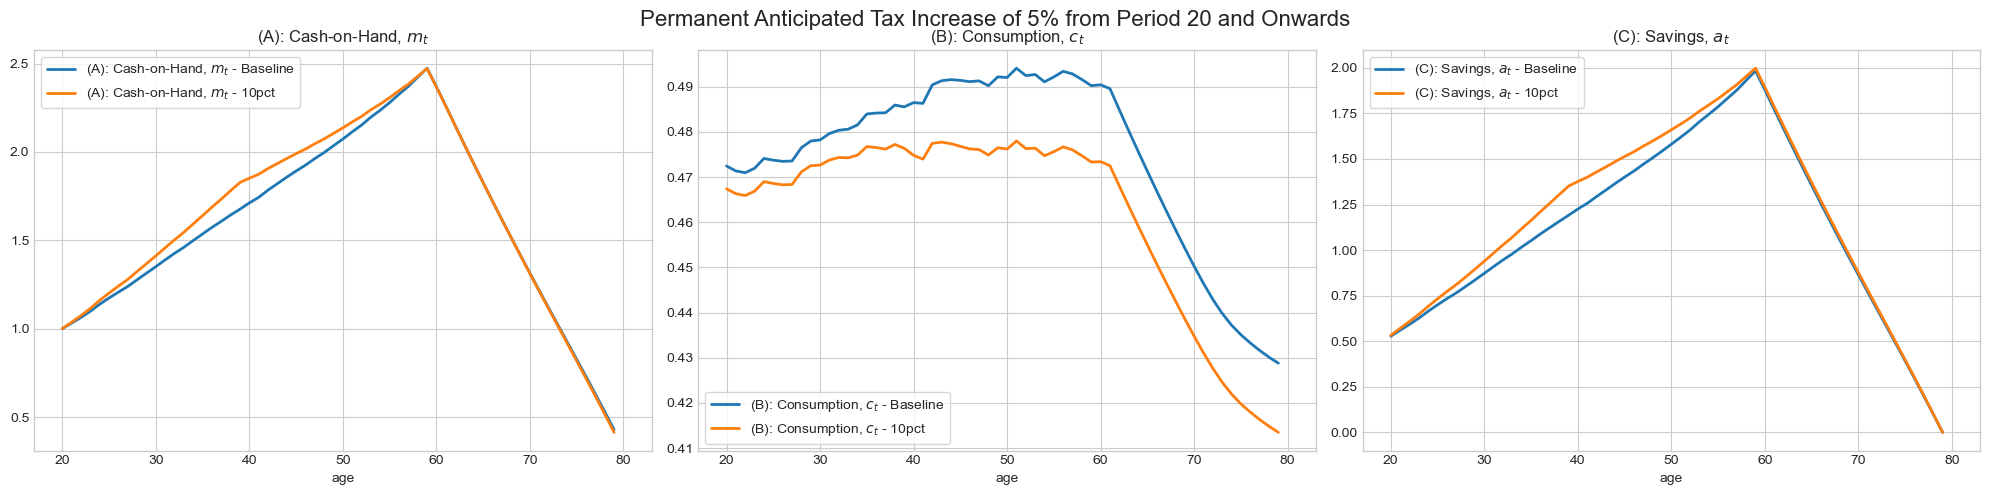

In [17]:
# a. unpack
par = model_egm.par
sim = model_egm.sim
sim_5pct = model_egm_5pct.sim

simvarlist = [('m','(A): Cash-on-Hand, $m_t$'),
              ('c','(B): Consumption, $c_t$'),
              ('a','(C): Savings, $a_t$')]

# b. figure
fig, axs = plt.subplots(1, len(simvarlist), figsize=(20, 5))

# add a title over the entire figure
fig.suptitle("Permanent Anticipated Tax Increase of 5% from Period 20 and Onwards", fontsize=16)

age = np.arange(par.T)

for i, (simvar,simvarlatex) in enumerate(simvarlist):

    simdata = getattr(sim,simvar+'_rand')
    simdata_5pct = getattr(sim_5pct,simvar+'_rand')
    axs[i].plot(age,np.mean(simdata,axis=1),lw=2,label=f'{simvarlatex} - Baseline')
    axs[i].plot(age,np.mean(simdata_5pct,axis=1),lw=2,label=f'{simvarlatex} - 10pct')

    axs[i].legend(frameon=True)
    axs[i].grid(True)
    axs[i].set_xlabel('age')
    axs[i].set_title(f'{simvarlatex}')

    # Change x-axis labels to show 20 years later
    xticks = axs[i].get_xticks()
    axs[i].set_xticks(xticks)  # Set tick positions, this line is actually redundant here because it's the same as before
    new_xticks = xticks + 20
    axs[i].set_xticklabels([int(val) if val.is_integer() else val for val in new_xticks])
    axs[i].set_xlim(-3, 63)

plt.tight_layout()
# Adjust the layout so that title does not overlap with the top plot
plt.subplots_adjust(top=0.9)
plt.show()

## Uanticipated Tax Increase

Create a copy of the original model solve with EGM and *unanticipated* permanent tax increase in period 20 (i.e., 20):

In [18]:
model_unanticipated5pct = model_egm.copy()

Replace the periods after 20 from the old_tax simulation with the new_tax simulation

In [19]:
for var in ['m', 'c', 'a']:
    sim_old = getattr(model_egm.sim, var+'_rand')
    sim_new = getattr(model_egm_5pct.sim, var+'_rand')
    sim_combined = np.copy(sim_old)  # Create a copy of the old simulation
    sim_combined[20:] = sim_new[20:]  # Replace the periods after 20 with the new simulation

    # Set the combined simulation in the original model
    setattr(model_unanticipated5pct.sim, f'{var}_rand', sim_combined)

Checking They Jump to Correct (New) Optimal Path:

In [20]:
print(
    model_egm.sim.c_rand[10,0]
    ,model_unanticipated5pct.sim.c_rand[10,0]
    ,model_unanticipated5pct.sim.c_rand[30,0]
    ,model_egm_5pct.sim.c_rand[30,0]
)

0.248207569378338 0.248207569378338 0.31884733800417636 0.31884733800417636


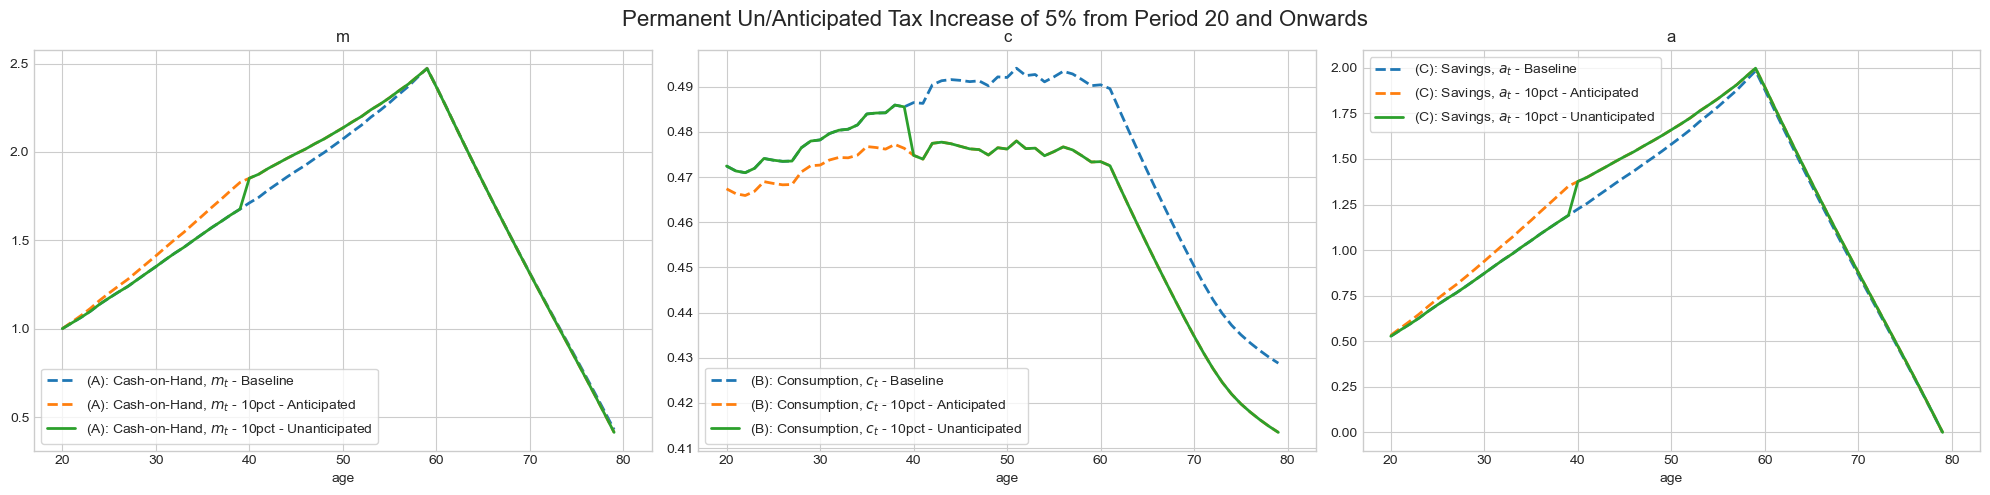

In [21]:
# a. unpack
par = model_egm.par
sim = model_egm.sim
sim_5pct = model_egm_5pct.sim
sim_unanticipated = model_unanticipated5pct.sim

simvarlist = [('m','(A): Cash-on-Hand, $m_t$'),
              ('c','(B): Consumption, $c_t$'),
              ('a','(C): Savings, $a_t$')]

# b. figure
fig, axs = plt.subplots(1, len(simvarlist), figsize=(20, 5))

# add a title over the entire figure
fig.suptitle("Permanent Un/Anticipated Tax Increase of 5% from Period 20 and Onwards", fontsize=16)

age = np.arange(par.T)

for i, (simvar,simvarlatex) in enumerate(simvarlist):

    simdata = getattr(sim, simvar+'_rand')
    simdata_5pct = getattr(sim_5pct, simvar+'_rand')
    simdata_unanticipated = getattr(sim_unanticipated, simvar+'_rand')  # data from combined model

    axs[i].plot(age, np.mean(simdata, axis=1), lw=2, linestyle = '--',label=f'{simvarlatex} - Baseline')
    axs[i].plot(age, np.mean(simdata_5pct, axis=1), lw=2, linestyle = '--', label=f'{simvarlatex} - 10pct - Anticipated')
    axs[i].plot(age, np.mean(simdata_unanticipated, axis=1), lw=2, label=f'{simvarlatex} - 10pct - Unanticipated')  # plot combined data

    axs[i].legend(frameon=True)
    axs[i].grid(True)
    axs[i].set_xlabel('age')
    axs[i].set_title(f'{simvar}')

    # Change x-axis labels to show 20 years later
    xticks = axs[i].get_xticks()
    axs[i].set_xticks(xticks)  # Set tick positions, this line is actually redundant here because it's the same as before
    new_xticks = xticks + 20
    axs[i].set_xticklabels([int(val) if val.is_integer() else val for val in new_xticks])
    axs[i].set_xlim(-3, 63)

plt.tight_layout()
# Adjust the layout so that title does not overlap with the top plot
plt.subplots_adjust(top=0.9)
plt.show()

# MPC

### MPC for Different Cohorts

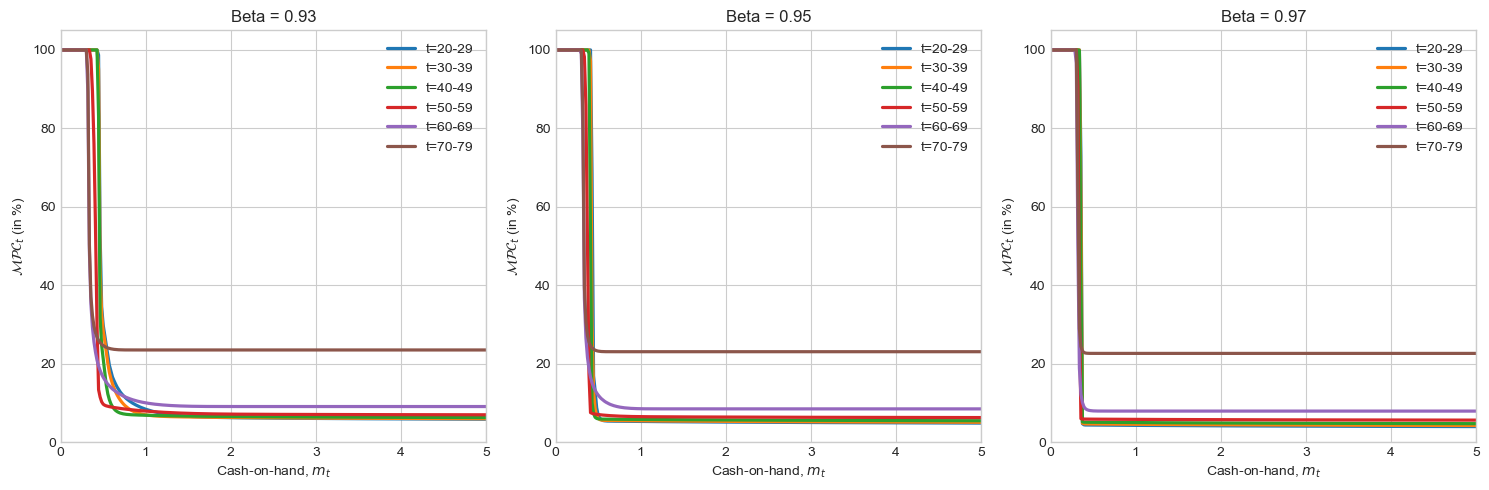

In [22]:
from consav import linear_interp

# unpack 
par = model_egm.par
sim = model_egm.sim
sol = model_egm.sol

p_bar = np.mean(sim.p,axis=2)
mpc_eps = 0.00749

# allocate memory
c0 = np.zeros(shape=(par.T,len(par.Betas), len(par.grid_m)))
c1 = np.zeros(shape=(par.T,len(par.Betas), len(par.grid_m)))
mpc = np.zeros(shape=(par.T,len(par.Betas), len(par.grid_m)))


for t in range(par.T):
    for b in range(len(par.Betas)):
        for i,m in enumerate(par.grid_m):
            c0[t,b,i] = linear_interp.interp_2d(par.grid_p,par.grid_m,sol.c[t,b],p_bar[t,b],m)
            c1[t,b,i] = linear_interp.interp_2d(par.grid_p,par.grid_m,sol.c[t,b],p_bar[t,b],m+mpc_eps)
            mpc[t,b,i] = (c1[t,b,i]-c0[t,b,i])/mpc_eps

fig, axs = plt.subplots(1, len(par.Betas), figsize=(15, 5))

for b in range(len(par.Betas)):
    for t in np.arange(0,par.T,10):
        axs[b].plot(par.grid_m, np.mean(mpc[t:t+9,b,:]*100,axis=0), label='t={}-{}'.format(t+par.Tmin,t+par.Tmin+9), lw=2.3)
        axs[b].set_xlim([0, 5])  # sets x-axis limit
        axs[b].set_ylim([0, 105])  # sets y-axis limit
        axs[b].set_title(f'Beta = {par.Betas[b].round(2)}')  # sets title for each subplot
        axs[b].set_xlabel('Cash-on-hand, $m_t$')
        axs[b].set_ylabel('$\mathcal{MPC}_t$ (in %)') 
        axs[b].legend() 

plt.tight_layout()
plt.show()

### Simulated MPC

In [23]:
model_egm.simulate()

model simulated in 0.0 secs


In [24]:
mean_mpc = np.mean(model_egm.sim.mpc)*100
mean_mpc

13.975599045145701

In [25]:
mean_mpc_working = np.mean(model_egm.sim.mpc[:model_egm.par.Tr-1,:,:])*100
mean_mpc_working

8.117166437876055

In [26]:
mean_mpc_retirement = np.mean(model_egm.sim.mpc[model_egm.par.Tr:,:,:])*100
mean_mpc_retirement

25.718887830394927

#### Lifecycle MPC for Different Betas

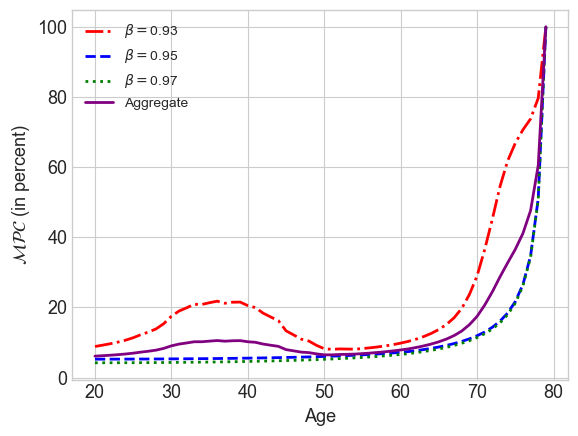

In [27]:
# beta values
betas = [0.93, 0.95, 0.97]  # add more values if num_betas > 3

# Different colors for different lines
colors = ['red', 'blue', 'green', 'black']  # add more colors if num_betas > 3

# Different line styles for different lines
line_styles = ['-.', '--', ':', '-']  # add more styles if num_betas > 3

# x-axis labels
age = np.arange(par.T) + par.Tmin

# Plot each beta index
for beta in range(len(betas)):
    plt.plot(age, np.mean(sim.mpc[:, beta, :]*100, axis=1), lw=2, color=colors[beta], linestyle=line_styles[beta], label=r'$\beta=$' + str(betas[beta]))

# mean over beta and individual dimensions
mean_mpc_aggregate = np.mean(sim.mpc*100, axis=(1, 2))

# Plot aggregate over beta and individuals
plt.plot(age, mean_mpc_aggregate, lw=2, color='purple', linestyle='-', label='Aggregate')

# Set labels and fontsize
plt.xlabel('Age', fontsize=13)
plt.ylabel('$\mathcal{MPC}$ (in percent)', fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Show legend
plt.legend()

plt.show()

#### Simulations of MPC for Table in LaTeX

In [28]:
# define stages
stages = {
    'aggregate': (slice(None), slice(None), slice(None)),
    'working': (slice(model_egm.par.Tr-1), slice(None), slice(None)),
    'retirement': (slice(model_egm.par.Tr, None), slice(None), slice(None)),
}

# number of betas (assuming 3, adjust according to your data)
num_betas = 3

# store results in a dictionary
results = {}

# aggregate across all betas
for stage_name, stage_slice in stages.items():
    # calculate and store the mean
    results[f'mean_mpc_{stage_name}'] = np.mean(model_egm.sim.mpc[stage_slice]) * 100

# mean values for each beta index
for beta in range(num_betas):
    for stage_name, stage_slice in stages.items():
        # update the slice for the current beta
        beta_slice = (stage_slice[0], beta, stage_slice[2])
        # calculate and store the mean
        results[f'mean_mpc_{stage_name}_beta{beta}'] = np.mean(model_egm.sim.mpc[beta_slice]) * 100

# access results
for key, value in results.items():
    print(f'{key}: {value:.1f} pct.')

mean_mpc_aggregate: 14.0 pct.
mean_mpc_working: 8.1 pct.
mean_mpc_retirement: 25.7 pct.
mean_mpc_aggregate_beta0: 21.9 pct.
mean_mpc_working_beta0: 13.9 pct.
mean_mpc_retirement_beta0: 38.1 pct.
mean_mpc_aggregate_beta1: 10.4 pct.
mean_mpc_working_beta1: 5.7 pct.
mean_mpc_retirement_beta1: 19.8 pct.
mean_mpc_aggregate_beta2: 9.6 pct.
mean_mpc_working_beta2: 4.8 pct.
mean_mpc_retirement_beta2: 19.3 pct.


# Alternative Solution Methods

### Solved Using NVFI

In [29]:
model_nvfi = BufferStockModelClass(name='baseline',par={'solmethod':'nvfi'})

In [30]:
model_nvfi.solve()

 t = 59 solved in 1.3 secs
 t = 59 solved in 0.0 secs
 t = 59 solved in 0.0 secs
 t = 58 solved in 9.8 secs (w: 3.7 secs)
 t = 58 solved in 2.7 secs (w: 0.2 secs)
 t = 58 solved in 3.0 secs (w: 0.2 secs)
 t = 57 solved in 2.9 secs (w: 0.2 secs)
 t = 57 solved in 2.9 secs (w: 0.2 secs)
 t = 57 solved in 3.4 secs (w: 0.3 secs)
 t = 56 solved in 3.4 secs (w: 0.2 secs)
 t = 56 solved in 4.0 secs (w: 0.3 secs)
 t = 56 solved in 4.7 secs (w: 0.3 secs)
 t = 55 solved in 4.5 secs (w: 0.3 secs)
 t = 55 solved in 3.7 secs (w: 0.3 secs)
 t = 55 solved in 2.8 secs (w: 0.2 secs)
 t = 54 solved in 2.9 secs (w: 0.2 secs)
 t = 54 solved in 3.0 secs (w: 0.2 secs)
 t = 54 solved in 3.2 secs (w: 0.3 secs)
 t = 53 solved in 2.7 secs (w: 0.2 secs)
 t = 53 solved in 2.7 secs (w: 0.2 secs)
 t = 53 solved in 2.6 secs (w: 0.2 secs)
 t = 52 solved in 3.0 secs (w: 0.2 secs)
 t = 52 solved in 3.1 secs (w: 0.2 secs)
 t = 52 solved in 2.9 secs (w: 0.3 secs)
 t = 51 solved in 2.6 secs (w: 0.2 secs)
 t = 51 solved in

In [31]:
model_nvfi.simulate()

model simulated in 3.0 secs


In [32]:
model_nvfi.simulate_rand()

model simulated in 3.3 secs


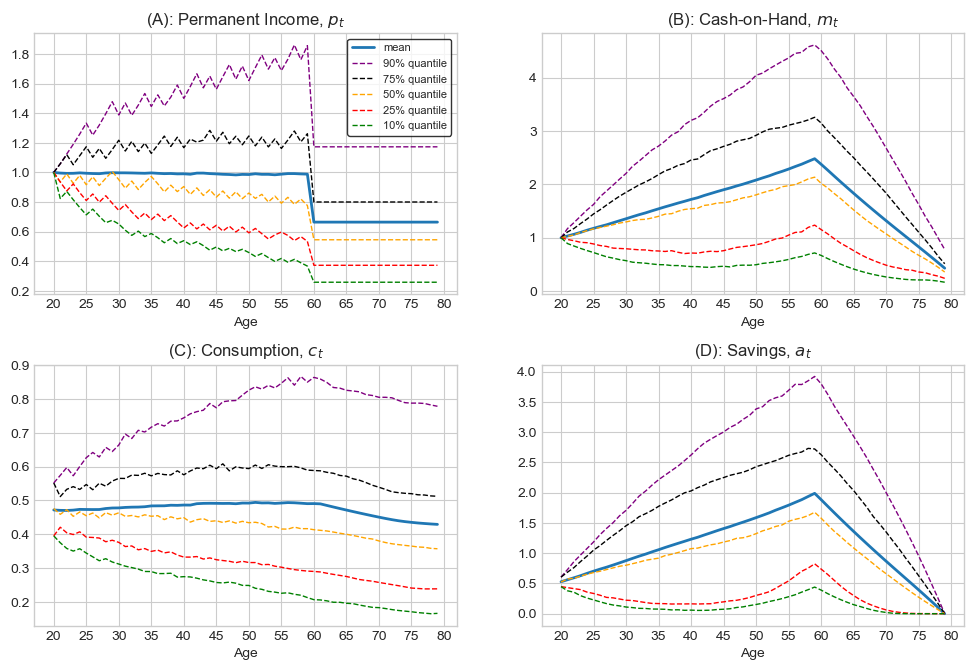

In [33]:
model_nvfi.lifecycle()

### Solved using VFI

In [34]:
model_vfi = BufferStockModelClass(name='baseline',par={'solmethod':'vfi'})

Purposely interupted due to long computation time.

In [35]:
model_vfi.solve()

 t = 59 solved in 1.3 secs
 t = 59 solved in 0.0 secs
 t = 59 solved in 0.0 secs
 t = 58 solved in 20.2 secs (w: 0.0 secs)


Traceback (most recent call last):
  File "c:\Users\olive\OneDrive - Københavns Universitet\KUonedriveOW\7. semester\DyProg\Playground\LostInOptimization\Jeppe\01. BufferStockModel\BufferStockModel.py", line 202, in solve
    vfi.solve_bellman(t,b,sol,par,beta)
KeyboardInterrupt


KeyboardInterrupt: 